#### Import training and test datasets

In [1]:
import os
import numpy as np

# Root directory is the second-parent directory of the current file
root_dir = os.path.dirname(os.path.dirname(os.getcwd()))

# Import training data
# First row: column labels as strings (skip)
# Every other row: label (string), pixel data array (28*28 = 784)
train_path = os.path.join(root_dir, "data", "digit-recognizer", "train.csv")
test_path = os.path.join(root_dir, "data", "digit-recognizer", "test.csv")
data_train_raw = np.loadtxt(train_path, delimiter=",", skiprows=1)
data_test_raw = np.loadtxt(test_path, delimiter=",", skiprows=1)

#### Display an image from the dataset

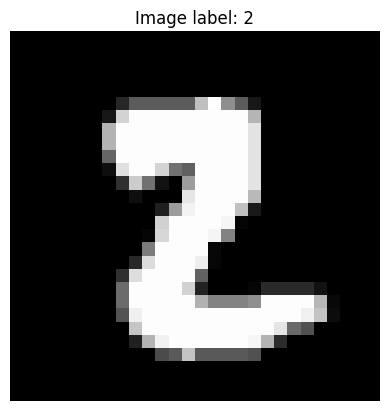

In [2]:
import matplotlib.pyplot as plt

# Select an image
image_num = 16

# Obtain label and pixel data for the image
label = data_train_raw[image_num][0]
image = data_train_raw[image_num][1:].reshape(28,28)

# Display the image and its label
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title(f"Image label: {int(label)}")
plt.show()

#### Check GPU and CUDA availability

In [3]:
import torch, subprocess

def disp(str1,str2): return print(str1.ljust(15),":",str2)
disp("PyTorch version",torch.__version__)
if not torch.cuda.is_available():
    print("ERROR: no CUDA visible to PyTorch!")
else:
    disp("CUDA available",torch.cuda.is_available())
    disp("CUDA version",torch.version.cuda)
    for i in range(torch.cuda.device_count()):
        p = torch.cuda.get_device_properties(i)
        disp(f"GPU {i}",f"{p.name}")
        disp(f"GPU {i} memory",f"{p.total_memory/1000**3:.2f} GB")

cmd = ['nvidia-smi', 
        '--query-gpu=memory.total,memory.used',
        '--format=csv,noheader,nounits']
out = subprocess.check_output(cmd).decode().strip()
total, used = map(int, out.split(", "))
disp("GPU memory used",f"{used} MiB / {total} MiB")

PyTorch version : 2.9.0+cu128
CUDA available  : True
CUDA version    : 12.8
GPU 0           : NVIDIA L40S
GPU 0 memory    : 47.81 GB
GPU memory used : 3 MiB / 46068 MiB


#### Train the model and validate its accuracy

In [2]:
import torch
from model.torch import TorchMLP

# Define PyTorch parameters.
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

# Inputs:
# For each sample, pixel values in range [0,1], flattened 28x28-pixel image.
inputs = torch.tensor(data_train_raw[:,1:]/255.0, dtype = DTYPE, device = DEVICE)
# Mean subtraction: subtract mean value across dataset to make features balanced.
inputs = (inputs - inputs.mean(0)) / (inputs.std(0)+10**(-9))
# Split data into training and validation datasets.
threshold = int(0.8 * inputs.shape[0])
inputs_train = inputs[:threshold]
inputs_validate = inputs[threshold:]

# Training data:
# For each sample, correct class as a non-negative integer.
data = torch.tensor(data_train_raw[:,0], dtype = torch.long, device = DEVICE)
data_train = data[:threshold]
data_validate = data[threshold:]

# Define MLP structure.
NUM_LAYERS = 5
DIM_HIDDEN = 512
MODEL = TorchMLP(num_layers = NUM_LAYERS, dim_hidden = DIM_HIDDEN, \
    model_type = "classifier", dtype = DTYPE, device = DEVICE)

# Train the model.
parameters_train, epochs, losses, accuracies = \
    MODEL.train_supervised(inputs_train, data_train, \
    num_epochs = 500, dim_batch = 1000, log_step = 5, rate_init = 0.001)

# Validate the accuracy.
val_loss, val_acc = MODEL.validate(inputs_validate, data_validate, parameters_train)


Epoch 500/500: loss 0.0138, accuracy 0.9956
Validation loss 0.1622, accuracy 0.9695


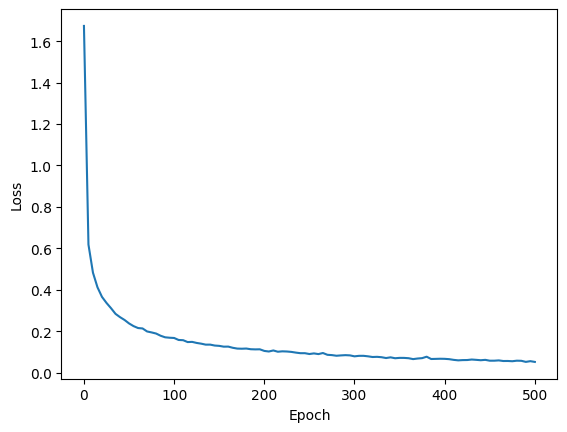

In [4]:
import matplotlib.pyplot as plt
# Plot the losses.
plt.plot(epochs,losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()